# Ex-05
## DEVELOPING A RECURRENT NEURAL NETWORK MODEL FOR STOCK PREDICTION
**Name** PRIYADHARSHINI S

**Reg no** 212223240129

**Slot** 4O1-1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [3]:
df_train = pd.read_csv(r"C:\Users\admin\Downloads\trainset.csv")
df_test = pd.read_csv(r"C:\Users\admin\Downloads\testset.csv")

In [4]:
train_prices = df_train['Close'].values.reshape(-1, 1)
test_prices = df_test['Close'].values.reshape(-1, 1)

In [5]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_test = scaler.transform(test_prices)

In [6]:
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 60
x_train, y_train = create_sequences(scaled_train, seq_length)
x_test, y_test = create_sequences(scaled_test, seq_length)


In [7]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1199, 60, 1), (1199, 1), (65, 60, 1), (65, 1))

In [8]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [9]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [10]:
class RNNModel(nn.Module):
    
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Take the last output
        out = self.fc(out)
        return out

In [11]:
model = RNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [13]:
!pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable


In [14]:
from torchinfo import summary

In [15]:
summary(model, input_size=(64, 60, 1))

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [64, 1]                   --
├─RNN: 1-1                               [64, 60, 64]              12,608
├─Linear: 1-2                            [64, 1]                   65
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 48.42
Input size (MB): 0.02
Forward/backward pass size (MB): 1.97
Params size (MB): 0.05
Estimated Total Size (MB): 2.03

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
train_losses = []
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    train_losses.append(average_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}")

Epoch 1/50, Loss: 0.0455
Epoch 2/50, Loss: 0.0060
Epoch 3/50, Loss: 0.0014
Epoch 4/50, Loss: 0.0006
Epoch 5/50, Loss: 0.0004
Epoch 6/50, Loss: 0.0004
Epoch 7/50, Loss: 0.0004
Epoch 8/50, Loss: 0.0004
Epoch 9/50, Loss: 0.0004
Epoch 10/50, Loss: 0.0004
Epoch 11/50, Loss: 0.0004
Epoch 12/50, Loss: 0.0003
Epoch 13/50, Loss: 0.0003
Epoch 14/50, Loss: 0.0003
Epoch 15/50, Loss: 0.0003
Epoch 16/50, Loss: 0.0003
Epoch 17/50, Loss: 0.0004
Epoch 18/50, Loss: 0.0004
Epoch 19/50, Loss: 0.0003
Epoch 20/50, Loss: 0.0003
Epoch 21/50, Loss: 0.0003
Epoch 22/50, Loss: 0.0003
Epoch 23/50, Loss: 0.0003
Epoch 24/50, Loss: 0.0003
Epoch 25/50, Loss: 0.0003
Epoch 26/50, Loss: 0.0003
Epoch 27/50, Loss: 0.0003
Epoch 28/50, Loss: 0.0003
Epoch 29/50, Loss: 0.0003
Epoch 30/50, Loss: 0.0003
Epoch 31/50, Loss: 0.0003
Epoch 32/50, Loss: 0.0003
Epoch 33/50, Loss: 0.0003
Epoch 34/50, Loss: 0.0003
Epoch 35/50, Loss: 0.0003
Epoch 36/50, Loss: 0.0003
Epoch 37/50, Loss: 0.0003
Epoch 38/50, Loss: 0.0003
Epoch 39/50, Loss: 0.

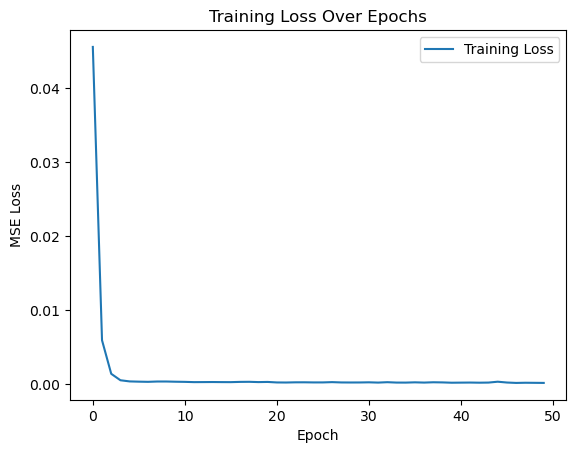

In [18]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

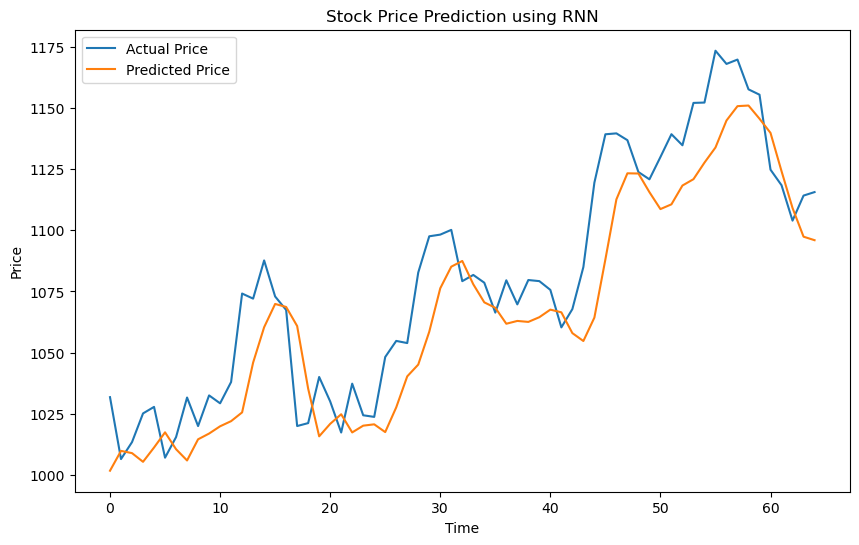

Predicted Price: [1095.9813]
Actual Price: [1115.65]


In [19]:
model.eval()
with torch.no_grad():
    predicted = model(x_test_tensor.to(device)).cpu().numpy()
    actual = y_test_tensor.cpu().numpy()

predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(actual)

plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using RNN')
plt.legend()
plt.show()
print(f'Predicted Price: {predicted_prices[-1]}')
print(f'Actual Price: {actual_prices[-1]}')